0.0017827986386978125
0.0017827986386978125
0.0017827986386978125
0.0017827986386978125
0.0017827986386978125
0.0017827986386978125
0.0017827986386978125
0.0017827986386978125
0.0017827986386978125
0.0017827986386978125
0.0017827986386978125
0.0017827986386978125
0.0017827986386978125
0.0017827986386978125
0.0017827986386978125
0.0017827986386978125
0.0017827986386978125
0.0017827986386978125
0.0017827986386978125
0.0017827986386978125
0.0017827986386978125
0.0017827986386978125
0.0017827986386978125
0.0017827986386978125
0.0017827986386978125
0.0017827986386978125
0.0017827986386978125
0.0017827986386978125
0.0017827986386978125
0.0017827986386978125
0.0017827986386978125
0.0017827986386978125
0.0017827986386978125
0.0017827986386978125
0.0017827986386978125
0.0017827986386978125
0.0017827986386978125
0.0017827986386978125
0.0017827986386978125
0.0017827986386978125
0.0017827986386978125
0.0017827986386978125
0.0017827986386978125
0.0017827986386978125
0.0017827986386978125
0.00178279

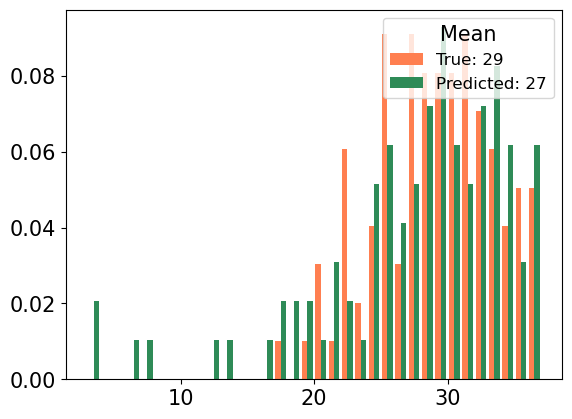

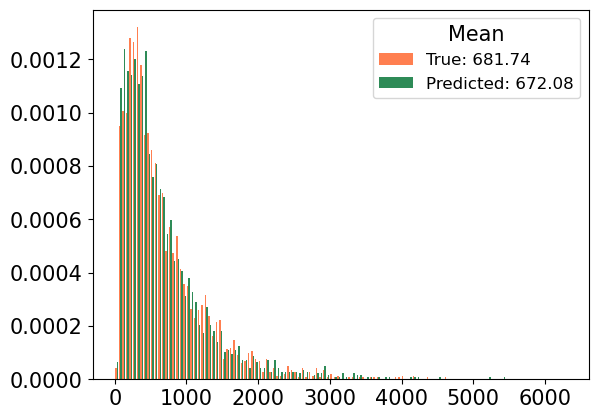

In [2]:
#### Using the fixed seeds from 1 to 100

import numpy as np
import networkx as nx
import os.path
import matplotlib.pyplot as plt
import time
import math
import gc

gc.collect()
import warnings
warnings.filterwarnings("ignore")
import os
os.system('cls' if os.name == 'nt' else 'clear')
plt.rc('font',size=15)

start = time.time() 
"""SDE: double well
"""
#self.M is the ODE's dimension
#self.N is the number of reservoir node
#self.S is training data
#self.R is collection of reservoir state vectors: bias, reservoir variable, system variable
#self.r seems the reservoir variables


UseDoubleWell=1
RCType=0# Different RC architecture: 0 deterministic RC to learn noise; 1/2 with noise in/out side tanh
dt = 0.002 #steplength
TestLength=20000#00 # Number of points for test/validation phase: 0.01 steplength
T2 =40+TestLength*dt  # Total time length: including training phase and test/validation phase
T_atimes=[]
T_ptimes=[]
T_ainterval=[]
T_pinterval=[]
xanoise=[]
yanoise=[]


def distribution(u,times,interval):#To evaluate the transition time and number
    xshape=np.shape(u)[0]
    yshape=np.shape(u)[1]
    Length=max(xshape,yshape)
    length=min(xshape,yshape)
    transtep=50 
    count=0
    index_up=0
    index_down=0
    diff=[[],[]]
    position=[[],[]]
    if xshape > yshape: 
        u = u.T
    sign=np.sign(u)   
    for i in range(Length-1):
        for j in range(length):
            diff[j].append(u[j,i+1]-u[j,i])
            if diff[j][i]!=0:
                position[j].append(i)
    
    for i in range(Length):
        if u[0,i] != 0:
            state=sign[0,i]
            index_up=i
            index_down=i
            break
#------------------------------------------------------------------------------    
    i=0
    while(i < Length-1):
        if i < Length - transtep -1:
            if state < 0:
                if u[0,i] <0 and u[0,i+1] >=0: 
                    if (u[0,i+1:i+transtep]>=0).all():
                        index_up=i
                        count+=1
                        interval.append(index_up-index_down)
                        i+=transtep
                        state=1
                    else:
                        i+=1
                else:
                    i+=1
            else:
                if u[0,i] >0 and u[0,i+1] <=0:
                    if (u[0,i+1:i+transtep]<=0).all():
                        index_down=i
                        count+=1
                        interval.append(index_down-index_up)
                        i+=transtep
                        state=-1
                    else:
                        i+=1
                else:
                    i+=1
        else:
            if state < 0:
                if u[0,i] <0 and u[0,i+1] >=0: 
                    if (u[0,i+1:]>=0).all():
                        index_up=i
                        count+=1
                        interval.append(index_up-index_down)
                        i+=transtep
                        state=1
                    else:
                        i+=1
                else:
                    i+=1
            else:
                if u[0,i] >0 and u[0,i+1] <=0:
                    if (u[0,i+1:]<=0).all():
                        index_down=i
                        count+=1
                        interval.append(index_down-index_up)
                        i+=transtep
                        state=-1
                    else:
                        i+=1
                else:
                    i+=1
    times.append(count)

def draw_distribution(a,b,title,xlable,bins_interval=1,margin=1):#To draw the PDF of evaluation between test and predicted data
    data=[a,b]
    left = min(np.min(a),np.min(b))
    right = max(np.max(a),np.max(b))
    bins= np.arange(math.floor(left), math.ceil(right), bins_interval)
    plt.xlim(math.floor(left) - margin, math.ceil(right) + margin)
    plt.xlabel(xlable) 
    plt.ylabel('Frequency')   
    plt.clf()
    plt.hist(data, bins=bins, density=True, color=['coral','seagreen'])
    if xlable == 'Number' :
        plt.legend(['True: '+str(round(np.mean(a))),'Predicted: '+str(round(np.mean(b)))],title='Mean',fontsize=12,loc='upper right')
    else:
        plt.legend(['True: '+str(round(np.mean(a),2)),'Predicted: '+str(round(np.mean(b),2))],title='Mean' ,fontsize=12,loc='upper right')
    # plt.savefig('../results/' + title + '.pdf',bbox_inches = 'tight')
    plt.show()

def DoubleWell(para): #Generate dataset
    dimensions = 2
    a = 5;    b = 5;    c = 0;    epsilon = 0.3
    u = np.zeros((dimensions, int(T2/dt)+1))
    q = np.zeros((dimensions, int(T2/dt)))
    u[0,0] = 0
    u[1,0] = 2  
    for i in range (int(T2/dt)):
        u[0,i+1] = u[0,i] + dt * (-b*(-u[0,i]+u[0,i]**3+c) -a*u[1,i]) 
        u[1,i+1] = u[1,i] + dt * (a*(-u[0,i]+u[0,i]**3+c) -b*u[1,i]) 
        
        q[0,i] = np.sqrt(dt*2*epsilon*b) * np.random.randn()
        q[1,i] = np.sqrt(dt*2*epsilon*b) * np.random.randn()
        if i >=20000:
            xanoise.append(q[0,i])
            yanoise.append(q[1,i])
        
        u[0,i+1]=u[0,i+1]+q[0,i]
        u[1,i+1]=u[1,i+1]+q[1,i]

    #plt.scatter(u[0,20000:],u[1,20000:],c='coral',s=0.4)
    
    #plt.xlim(-2,2)
    #plt.ylim(-2,2)
    #plt.xlabel('$x$',fontsize=12)
    #plt.ylabel('$y$',fontsize=12)

    #plt.savefig('xyatra.svg',bbox_inches = 'tight')
    #plt.show()
    u_t=np.zeros((1,TestLength))
    u_t[0,:]=u[0,20001:int(T2/dt)+1]
    distribution(u_t,T_atimes,T_ainterval)


    return u
    
class Reservoir:
    def __init__(self,Utotal,hyperparameters):      
        # Input layer
        u=Utotal[0]
        self.NumBifurPara=np.shape(Utotal)[0]
        self.M = u.shape[0]
        self.input_len = u.shape[1]
        self.input_func = []
        self.dataset = Utotal

        # Reservoir layer
        self.N = 1200
        self.dimensions = 2
        self.P = u.shape[0]
        self.bias = 0 #fixed in current code
        
        # Training relevant: have used their ratio of separating the input data
        self.init_len = 0
        self.train_len = np.int(self.input_len-TestLength-1)
        self.test_len = np.int(TestLength)
        self.error_len = np.int(TestLength)
        self.T2=self.input_len
        
        # Hyperparameters to be optimized: here set their initial value of hyperparameters
        self.kin =hyperparameters[0] # uniform distribution of $[-k_{in},k_{in}]$ of W_{in}, W_{b}, W_{\epsilon}
        self.D = hyperparameters[1] # degree of reservoir matrix A ... self.degree_func(self.N) #What is the degree function in their code: the degree of the renyi-Erdos network
        self.rho = hyperparameters[2] # spectral radius: rho  -> "appropriately scaled by its largest eigenvalue ρ."
        self.alpha =hyperparameters[3] 
        self.beta = hyperparameters[4] 
        self.parab=0  #set as zero for now, because no para-layer yet
        self.parak=0  #set as zero for now, because no para-layer yet
        self.paraepsilon=0 #epsilon for RC and consistent with SDE model

        
    def train(self,parascanRange):  #To train W_{out}
        self.Win =np.random.uniform(-self.kin,self.kin, (self.N, self.M + 1))
        self.Wb= np.random.uniform(-self.kin, self.kin, (self.N, 1))
        self.Wxi=np.random.uniform(-self.kin,self.kin, (self.N, self.M)) 
        # TODO: the values of non-zero elements are randomly drawn from uniform dist [-1, 1]
        g = nx.erdos_renyi_graph(self.N, self.D / self.N, 42, True)
        self.A = nx.adjacency_matrix(g).todense()
        ## spectral radius: rho  -> "appropriately scaled by its largest eigenvalue ρ."
        self.A =self.A *1.25/self.rho 
        print(max(abs(np.linalg.eig(self.A)[0])))
        
        # run the reservoir with the data and collect r
        self.rFinalTrainTotal=[]
        for index in range(self.NumBifurPara):
            self.paralayer=parascanRange[index]
            self.R = np.zeros(
                    (1 + self.N + self.M, self.train_len-self.init_len ))
                # collection of input signals
            self.S = np.vstack((x[self.init_len + 1: self.train_len + 1] for x in self.dataset[index])) # make multi-dimensional input data from training window
            self.r = np.zeros((self.N, 1))
            for t in range(self.train_len):
                V = np.vstack((x[t] for x in self.dataset[index]))
                Xi= np.random.normal(0,1, (self.M, 1))#Gaussian white noise
                if RCType==0:
                    #RC0: 0 deterministic RC to learn noise
                    self.r = (1 - self.alpha) * self.r + self.alpha * np.tanh(np.dot(self.A,self.r) 
                          + np.dot(self.Win, np.vstack((self.bias, V)))+self.parak*np.dot(self.Wb, self.paralayer+self.parab))
                if RCType==1:
                    #RC1: noise inside tanh
                    self.r = (1 - self.alpha) * self.r + self.alpha * np.tanh(np.dot(self.A,self.r) 
                          + np.dot(self.Win, np.vstack((self.bias, V)))+self.parak*np.dot(self.Wb, self.paralayer+self.parab)
                          + np.sqrt(self.paraepsilon)*np.dot(self.Wxi,Xi))            
                if RCType==2:
                    #RC2: noise outside tanh
                    self.r = (1 - self.alpha) * self.r + self.alpha * (np.tanh(np.dot(self.A,self.r) 
                         + np.dot(self.Win, np.vstack((self.bias, V)))+self.parak*np.dot(self.Wb, self.paralayer+self.parab))
                         + np.sqrt(self.paraepsilon)*np.dot(self.Wxi,Xi)) 
                if t >= self.init_len:
                    self.R[:, [t - self.init_len]
                           ] = np.vstack((self.bias, V, self.r))[:, 0]
            if index==0:
                self.RTotal=self.R
                self.STotal=self.S             
            else:            
                self.RTotal=np.append(self.RTotal,self.R, axis=1)
                self.STotal=np.append(self.STotal,self.S, axis=1)
            self.rFinalTrainTotal.append(self.r[:,-1])

        # train the output
        R = self.RTotal  # Transpose
        R_T=R.T
        self.Wout = np.dot(np.dot(self.STotal, R_T), np.linalg.inv(
            np.dot(self.RTotal, R_T) + self.beta * np.eye(self.M + self.N + 1)))
        return self.Wout

    def train2(self,WoutPara):  #Seperate noise
        # use $W_{out}$ to get the deviation to approximate the noise distribution.
        global t
        self.SampledNoise = []
        for index in range(self.NumBifurPara):
            self.paralayer=parascanRange[index]
            self.R = np.zeros(
                    (1 + self.N + self.M, self.train_len - self.init_len))
            self.S = np.vstack((x[self.init_len + 1: self.train_len + 1] for x in self.dataset[index])) # make multi-dimensional input data from training window
            self.r = np.zeros((self.N, 1))
            for t in range(self.train_len):
                V = np.vstack((x[t] for x in self.dataset[index]))
                
                #RC0: 0 deterministic RC to learn noise
                self.r = (1 - self.alpha) * self.r + self.alpha * np.tanh(np.dot(self.A,self.r) 
                          + np.dot(self.Win, np.vstack((self.bias, V)))+self.parak*np.dot(self.Wb, self.paralayer+self.parab))
                s = np.dot(WoutPara, np.vstack((self.bias, V, self.r)))
                
                self.S[:, t] = np.squeeze(np.asarray(s))

            for i in range(self.dimensions):
              X=self.dataset[index][np.array(range(int(self.P/self.dimensions)))*self.dimensions+i, 1: self.train_len + 1]
              Y=self.S[np.array(range(int(self.P/self.dimensions)))*self.dimensions+i, 0: self.train_len ] 
              SampledNoise=[]
              for j in range(X.shape[1]):
                  XX=np.array(X[:,j])  
                  YY=np.array(Y[:,j])
                  NoiseTemp=XX-YY
                  Bins=max(5,int(np.sqrt(X.shape[0])))
                  hist, bins = np.histogram(NoiseTemp, bins=Bins,range=(min(NoiseTemp),max(NoiseTemp)), density=True)
                  bin_midpoints = bins[:-1] + np.diff(bins)/2
                  cdf = np.cumsum(hist)
                  cdf = cdf / cdf[-1]
                  values = np.random.rand(X.shape[0])
                  value_bins = np.searchsorted(cdf, values)
                  random_from_cdf = bin_midpoints[value_bins]
                  if j<0:#show the fitting to the noise distribution
                        plt.subplot(121)
                        plt.hist(NoiseTemp, Bins)
                        plt.subplot(122)
                        plt.hist(random_from_cdf, Bins)
                        plt.show()
                  
                  SampledNoise.append(random_from_cdf)
              self.SampledNoise.append(SampledNoise) 
        
    
    def _run(self,WoutPara,Load,Predict):
        # run the trained ESN in alpha generative mode. no need to initialize here,
        # because r is initialized with training data and we continue from there.
        output=[[],[]]
        if Load==0:
            # current_dir = os.path.dirname(os.path.abspath(__file__))
            current_dir = os.getcwd()
            np.save(os.path.join(current_dir, 'xyWinw.npy'), self.Win)
            np.save(os.path.join(current_dir, 'xyAw.npy'), self.A)
            np.save(os.path.join(current_dir, 'xyWoutParaw.npy'), WoutPara)
            np.save(os.path.join(current_dir, 'xyWb.npy'), self.Wb)
            np.save(os.path.join(current_dir, 'xyWxi.npy'), self.Wxi)
            np.save(os.path.join(current_dir, 'xyr.npy'), self.rFinalTrainTotal)
        else:
            self.Win=np.load(r'../data/2d bistable non-gradient system/xyWinw.npy')
            self.A=np.load(r'../data/2d bistable non-gradient system/xyAw.npy')
            WoutPara=np.load(r'../data/2d bistable non-gradient system/xyWoutParaw.npy')
            self.Wb=np.load(r'../data/2d bistable non-gradient system/xyWb.npy')
            self.Wxi=np.load(r'../data/2d bistable non-gradient system/xyWxi.npy')
            self.rFinalTrainTotal=np.load(r'../data/2d bistable non-gradient system/xyr.npy')
        
        self.S = np.zeros((self.P, self.test_len))
        self.S_1 = np.zeros((self.P, self.test_len))
        self.S_2 = np.zeros((self.P, self.test_len))
        self.S_3 = np.zeros((self.P, self.test_len))
        self.S_4 = np.zeros((self.P, self.test_len))
        self.S_5 = np.zeros((self.P, self.test_len))
        self.S_6 = np.zeros((self.P, self.test_len))
        self.S_7 = np.zeros((self.P, self.test_len))
        self.S_8 = np.zeros((self.P, self.test_len))
        self.S_9 = np.zeros((self.P, self.test_len))

        
        for index in range(self.NumBifurPara):
            V = np.vstack((x[self.train_len] for x in self.dataset[index]))
            V_1 = np.vstack((x[self.train_len] for x in self.dataset[index]))
            V_2 = np.vstack((x[self.train_len] for x in self.dataset[index]))
            V_3 = np.vstack((x[self.train_len] for x in self.dataset[index]))
            V_4 = np.vstack((x[self.train_len] for x in self.dataset[index]))
            V_5 = np.vstack((x[self.train_len] for x in self.dataset[index]))
            V_6 = np.vstack((x[self.train_len] for x in self.dataset[index]))
            V_7 = np.vstack((x[self.train_len] for x in self.dataset[index]))
            V_8 = np.vstack((x[self.train_len] for x in self.dataset[index]))
            V_9 = np.vstack((x[self.train_len] for x in self.dataset[index]))
            
            if Predict == 0:
                V[:,0]=(-1.5,1)
                V_1[:,0]=(-1,1)
                V_2[:,0]=(-1.5,0)
                V_3[:,0]=(-1.5,-1)
                V_4[:,0]=(-1,-1)
                V_5[:,0]=(1.5,1)
                V_6[:,0]=(1,1)
                V_7[:,0]=(1.5,0)
                V_8[:,0]=(1.5,-1)
                V_9[:,0]=(1,-1)
                        
            if Predict == 0:
                self.r=self.rFinalTrainTotal[index]
                self.r_1=self.rFinalTrainTotal[index]
                self.r_2=self.rFinalTrainTotal[index]
                self.r_3=self.rFinalTrainTotal[index]
                self.r_4=self.rFinalTrainTotal[index]
                self.r_5=self.rFinalTrainTotal[index]
                self.r_6=self.rFinalTrainTotal[index]
                self.r_7=self.rFinalTrainTotal[index]
                self.r_8=self.rFinalTrainTotal[index]
                self.r_9=self.rFinalTrainTotal[index]
            else:
                self.r=self.rFinalTrainTotal[index]*0

            if RCType==0:
                
                global NoiseToUse
                NoiseToUse=np.array(self.SampledNoise)
                

            for t in range(self.test_len):
                # r(t + \Delta t) = (1 - alpha)r(t) + alpha * tanh(A * r(t) + Win * V(t) + bias)
                if RCType==0:
                    #RC0: 0 deterministic RC to learn noise
                    self.r = (1 - self.alpha) * self.r + self.alpha * np.tanh(np.dot(self.A,self.r) 
                          + np.dot(self.Win, np.vstack((self.bias, V)))+self.parak*np.dot(self.Wb, self.paralayer+self.parab))
                                          
                    if Predict == 0:
                    
                        self.r_1 = (1 - self.alpha) * self.r_1 + self.alpha * np.tanh(np.dot(self.A,self.r_1) 
                              + np.dot(self.Win, np.vstack((self.bias, V_1)))+self.parak*np.dot(self.Wb, self.paralayer+self.parab))
                              
                        self.r_2 = (1 - self.alpha) * self.r_2 + self.alpha * np.tanh(np.dot(self.A,self.r_2) 
                              + np.dot(self.Win, np.vstack((self.bias, V_2)))+self.parak*np.dot(self.Wb, self.paralayer+self.parab))
                              
                        self.r_3 = (1 - self.alpha) * self.r_3 + self.alpha * np.tanh(np.dot(self.A,self.r_3) 
                              + np.dot(self.Win, np.vstack((self.bias, V_3)))+self.parak*np.dot(self.Wb, self.paralayer+self.parab))
                        
                        self.r_4 = (1 - self.alpha) * self.r_4 + self.alpha * np.tanh(np.dot(self.A,self.r_4) 
                              + np.dot(self.Win, np.vstack((self.bias, V_4)))+self.parak*np.dot(self.Wb, self.paralayer+self.parab))
                        
                        self.r_5 = (1 - self.alpha) * self.r_5 + self.alpha * np.tanh(np.dot(self.A,self.r_5) 
                              + np.dot(self.Win, np.vstack((self.bias, V_5)))+self.parak*np.dot(self.Wb, self.paralayer+self.parab))
                        
                        self.r_6 = (1 - self.alpha) * self.r_6 + self.alpha * np.tanh(np.dot(self.A,self.r_6) 
                              + np.dot(self.Win, np.vstack((self.bias, V_6)))+self.parak*np.dot(self.Wb, self.paralayer+self.parab))
                        
                        self.r_7 = (1 - self.alpha) * self.r_7 + self.alpha * np.tanh(np.dot(self.A,self.r_7) 
                              + np.dot(self.Win, np.vstack((self.bias, V_7)))+self.parak*np.dot(self.Wb, self.paralayer+self.parab))
                        
                        self.r_8 = (1 - self.alpha) * self.r_8 + self.alpha * np.tanh(np.dot(self.A,self.r_8) 
                              + np.dot(self.Win, np.vstack((self.bias, V_8)))+self.parak*np.dot(self.Wb, self.paralayer+self.parab))
                        
                        self.r_9 = (1 - self.alpha) * self.r_9 + self.alpha * np.tanh(np.dot(self.A,self.r_9) 
                              + np.dot(self.Win, np.vstack((self.bias, V_9)))+self.parak*np.dot(self.Wb, self.paralayer+self.parab))
         
                
                if np.isnan(np.sum(np.sum(np.array(self.r)))):
                    print('R')
                    print(np.max(V))
                    print(np.max(np.max(WoutPara)),np.min(np.min(WoutPara)))
      
                s = np.dot(WoutPara, np.vstack((self.bias, V, self.r)))
                if Predict ==0:
                    s_1 = np.dot(WoutPara, np.vstack((self.bias, V_1, self.r_1)))
                    s_2 = np.dot(WoutPara, np.vstack((self.bias, V_2, self.r_2)))
                    s_3 = np.dot(WoutPara, np.vstack((self.bias, V_3, self.r_3)))
                    s_4 = np.dot(WoutPara, np.vstack((self.bias, V_4, self.r_4)))
                    s_5 = np.dot(WoutPara, np.vstack((self.bias, V_5, self.r_5)))
                    s_6 = np.dot(WoutPara, np.vstack((self.bias, V_6, self.r_6)))
                    s_7 = np.dot(WoutPara, np.vstack((self.bias, V_7, self.r_7)))
                    s_8 = np.dot(WoutPara, np.vstack((self.bias, V_8, self.r_8)))
                    s_9 = np.dot(WoutPara, np.vstack((self.bias, V_9, self.r_9)))
                                
                
                self.S[:, t] = np.squeeze(np.asarray(s))
                if Predict ==0:
                    self.S_1[:, t] = np.squeeze(np.asarray(s_1))
                    self.S_2[:, t] = np.squeeze(np.asarray(s_2))
                    self.S_3[:, t] = np.squeeze(np.asarray(s_3))
                    self.S_4[:, t] = np.squeeze(np.asarray(s_4))
                    self.S_5[:, t] = np.squeeze(np.asarray(s_5))
                    self.S_6[:, t] = np.squeeze(np.asarray(s_6))
                    self.S_7[:, t] = np.squeeze(np.asarray(s_7))
                    self.S_8[:, t] = np.squeeze(np.asarray(s_8))
                    self.S_9[:, t] = np.squeeze(np.asarray(s_9))
                
                              
                if RCType==0:
                   
                    self.S[:, t] = self.S[:, t]
                    if Predict ==0:
                        self.S_1[:, t] = self.S_1[:, t]
                        self.S_2[:, t] = self.S_2[:, t]
                        self.S_3[:, t] = self.S_3[:, t]
                        self.S_4[:, t] = self.S_4[:, t]
                        self.S_5[:, t] = self.S_5[:, t]
                        self.S_6[:, t] = self.S_6[:, t]
                        self.S_7[:, t] = self.S_7[:, t]
                        self.S_8[:, t] = self.S_8[:, t]
                        self.S_9[:, t] = self.S_9[:, t]
                    
                xjp = np.random.randint(0, self.test_len-1)
                if Predict == 0:
                    V = s
                    V_1= s_1 
                    V_2 = s_2
                    V_3 = s_3
                    V_4 = s_4
                    V_5 = s_5
                    V_6 = s_6
                    V_7 = s_7
                    V_8 = s_8
                    V_9 = s_9
                else:
                    V[0,0] = s[0,0] +  NoiseToUse[0,xjp,0]
                    V[1,0] = s[1,0] +  NoiseToUse[1,xjp,0]
                    output[0].append(V[0,0])
                    output[1].append(V[1,0])
            if Predict == 1:    
                output=np.array(output)
                Output=output.reshape(2,self.test_len)
                distribution(Output,T_ptimes,T_pinterval)
            
            if Predict == 0:
                plt.xlabel('$x$',fontsize=12)
                plt.ylabel('$y$',fontsize=12)
                plt.axvline(x=-1,c='navy',ls='--',alpha=0.5)
                plt.axvline(x=1,c='navy',ls='--',alpha=0.5)
                plt.axhline(y=0,c='navy',ls='--',alpha=0.5)
                plt.scatter(self.S[0,:],self.S[1,:],s=0.6,c='red')
                plt.scatter(self.S_1[0,:],self.S_1[1,:],s=0.6,c='blue')
                plt.scatter(self.S_2[0,:],self.S_2[1,:],s=0.6,c='green')
                plt.scatter(self.S_3[0,:],self.S_3[1,:],s=0.6,c='black')
                plt.scatter(self.S_4[0,:],self.S_4[1,:],s=0.6,c='grey')
                plt.scatter(self.S_5[0,:],self.S_5[1,:],s=0.6,c='yellow')
                plt.scatter(self.S_6[0,:],self.S_6[1,:],s=0.6,c='pink')
                plt.scatter(self.S_7[0,:],self.S_7[1,:],s=0.6,c='purple')
                plt.scatter(self.S_8[0,:],self.S_8[1,:],s=0.6,c='orange')
                plt.scatter(self.S_9[0,:],self.S_9[1,:],s=0.6,c='brown')
                # plt.savefig('../results/deterministic.svg',bbox_inches = 'tight')
                plt.show()
                


def GenerateEnsemble(Realizations,para):
    for j in range(Realizations):
        uTemp=DoubleWell(para) 
        if j==0:
            u=uTemp
        else:
            u=np.vstack((u, uTemp))
    return u
                    
if __name__ == '__main__':
    
    if UseDoubleWell==1:
        
        for i in range (100):
            np.random.seed(i)  # Set the random seed for reproducibility
            Realizations=1
            parascanRange=[0.2]
            para=np.zeros(4)
            para[0]=5  # a
            para[1]=5  # b
            para[2]=0  # c
            para[3]=0.3  # epsilon  
            BinNumber=4
            
            rcpara=np.zeros(5)
            rcpara[0]=1   # K_{in}
            rcpara[1]=2.2   # D
            rcpara[2]=1500   # relevant to rho: rho=0.0017
            rcpara[3]=0.3  # alpha
            rcpara[4]=1e-7 # beta
            
            paraTest=parascanRange[0]  # 0.2
            para[2]=paraTest  # test parameter
            Utotal=[]
            u=GenerateEnsemble(Realizations,para)
            Utotal.append(u)
            r2 = Reservoir(Utotal,rcpara)
            WoutTempReal = r2.train([paraTest])  # Actually W_{out}
            Load=0  # Switch: 0 save matrices / 1 load saved matrices
            Predict=1  # Switch: 0 draw deterministic part / 1 draw predicted data
            if RCType==0:
                r2.train2(WoutTempReal)
            r2._run(WoutTempReal,Load,Predict)

        if Predict == 1:                   
            draw_distribution(T_atimes,T_ptimes, "Number of transitions", 'Number',bins_interval=1,margin=2)
            draw_distribution(T_ainterval, T_pinterval, "Transition time step", 'Time step ',bins_interval=50,margin=10)


    